In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-revenue-prediction/train.csv.zip
/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv
/kaggle/input/restaurant-revenue-prediction/test.csv.zip


In [65]:
train_data = pd.read_csv("/kaggle/input/restaurant-revenue-prediction/train.csv.zip")
test_data = pd.read_csv("/kaggle/input/restaurant-revenue-prediction/test.csv.zip")

print('train data - ', train_data.shape)
print('test data - ', test_data.shape)

train data -  (137, 43)
test data -  (100000, 42)


In [66]:
train_data.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [133]:
X = train_data.drop('revenue', axis = 1)
Y = train_data['revenue']

<h1>Data fields</h1>

* Id : Restaurant id. 
* Open Date : opening date for a restaurant
* City : City that the restaurant is in. Note that there are unicode in the names. 
* City Group: Type of the city. Big cities, or Other. 
* Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
* P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
* Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

In [68]:
train_data.nunique()

Id            137
Open Date     134
City           34
City Group      2
Type            3
P1              8
P2              8
P3              8
P4              6
P5              7
P6              8
P7              6
P8              8
P9              4
P10             4
P11             8
P12             7
P13             5
P14            10
P15             8
P16             9
P17             9
P18             7
P19             9
P20             9
P21             8
P22             5
P23             9
P24             9
P25             8
P26            10
P27             9
P28             9
P29             7
P30             9
P31            10
P32            10
P33             6
P34             8
P35             8
P36             8
P37             8
revenue       137
dtype: int64

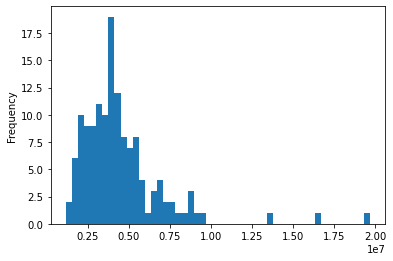

In [69]:
train_data['revenue'].plot.hist(bins = 50)

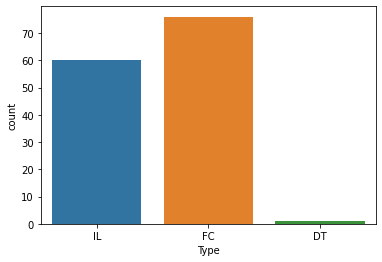

In [117]:
sns.countplot(train_data['Type'])

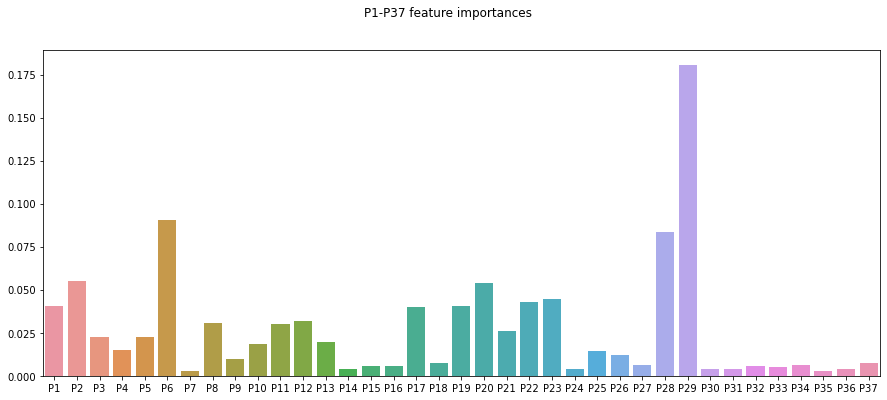

In [99]:
fig = plt.figure(figsize=(15, 6))
fig.suptitle('P1-P37 feature importances')
rfr = RandomForestRegressor()
rfr.fit(train_data[[f'P{i}' for i in range(1, 38)]], train_data['revenue'])
sns.barplot(x=[f'P{i}' for i in range(1, 38)], y = rfr.feature_importances_)
plt.show()

In [97]:
pd.to_datetime(train_data['Open Date']).apply(lambda d: d.year)

0      1999
1      2008
2      2013
3      2012
4      2009
       ... 
132    2008
133    2006
134    2006
135    2010
136    2009
Name: Open Date, Length: 137, dtype: int64

In [125]:
cityEncoder = LabelEncoder()
cityEncoder.fit(test_data['City Group'])
typeEncoder = LabelEncoder()
typeEncoder.fit(test_data['Type'])
def preprocess(X):
    res = X.copy()
    res['Type'] = typeEncoder.transform(X['Type'])
    res['City Group'] = cityEncoder.transform(X['City Group'])
    res['open lambda'] = (pd.to_datetime(X['Open Date']).max() - pd.to_datetime(X['Open Date']))
    
    res['Open year'] = pd.to_datetime(X['Open Date']).apply(lambda d: d.year)
    res['Open month'] = pd.to_datetime(X['Open Date']).apply(lambda d: d.month)
    
    res['OpenDays'] = res['open lambda'].apply(lambda d: d.days)
    #res['OpenYears'] = res['open lambda'].apply(lambda d: d.days // 365)
    res = res.drop('Open Date', axis = 1)
    res = res.drop('City', axis = 1)
    res = res.drop('open lambda', axis = 1)
    for i in range(1, 37):
        if rfr.feature_importances_[i] < 0.03:
            res = res.drop(f"P{i}", axis = 1)
    return res
X_preprocessed = preprocess(X)  
X_test_preprocessed = preprocess(test_data)
X_preprocessed.head()    

,Id,City Group,Type,P1,P5,P7,P11,P16,P18,P19,P21,P22,P27,P28,P37,Open year,Open month,OpenDays
0,0,0,2,4,2,5,3,2,4,5,1,3,4.0,2.0,4,1999,7,5306
1,1,0,1,4,1,5,1,0,0,3,1,3,0.0,3.0,0,2008,2,2172
2,2,1,2,2,2,5,2,0,0,1,1,1,0.0,1.0,0,2013,3,322
3,3,1,2,6,4,10,8,9,12,20,6,1,2.5,2.5,6,2012,2,723
4,4,1,2,3,2,5,2,2,4,2,1,2,5.0,1.0,3,2009,5,1722


Text(0.5, 1.0, 'Open restaurants count by year')

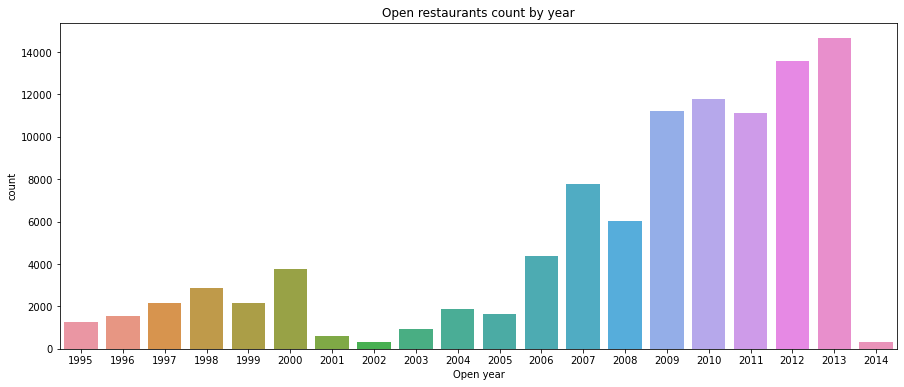

In [127]:
fig = plt.figure(figsize= (15, 6))
sns.countplot(X_test_preprocessed['Open year'])
plt.title("Open restaurants count by year")

<h1>Model</h1>

In [141]:
regressors = {
    'Linear Regression' : LinearRegression(),
    'Decision Tree' : DecisionTreeRegressor(),
    'Random Forest' : RandomForestRegressor(),
    'Support Vector Machines' : SVR(),
    'K-nearest Neighbors' : KNeighborsRegressor(),
    'XGBoost' : XGBRegressor()
}
results=pd.DataFrame(columns=['MAE','MSE','R2-score'])
for method,func in regressors.items():
    func.fit(X_preprocessed,Y)
    pred = func.predict(X_preprocessed)
    results.loc[method]= [mean_absolute_error(Y,pred),
                          mean_squared_error(Y,pred),
                          r2_score(Y,pred)
                         ]
results

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,MAE,MSE,R2-score
Linear Regression,1.641857e+06,5.318578e+12,0.192651
Logistic Regression,4.668666e+04,1.101719e+11,0.983276
Decision Tree,0.000000e+00,0.000000e+00,1.000000
Random Forest,6.835097e+05,1.005237e+12,0.847407
Support Vector Machines,1.603194e+06,6.851619e+12,-0.040062
K-nearest Neighbors,1.486231e+06,4.507007e+12,0.315846
XGBoost,4.618066e+01,4.945183e+03,1.000000
